###**Redes Siamesas**

Las redes siamesas son un tipo de arquitectura de redes neuronales diseñadas para aprender similitudes entre pares de entradas, como imágenes, secuencias o textos. La característica clave de estas redes es que constan de dos (o más) subredes idénticas que comparten los mismos pesos y parámetros. Cada subred procesa una entrada diferente, y luego las salidas (o embeddings) se comparan utilizando una métrica de similitud o distancia.




In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import LFWPairs
from sklearn.model_selection import train_test_split
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

Modificamos la clase Module de Pytorch, de manera que podamos pasar en el método *forward pass* dos imágenes o *inputs* en lugar de uno. Así, la red se adaptará a nuestro dataset que explicaremos ahora más adelante.

$$$$

Respecto a la filosofía de las redes siamesas no hay problema. Si aplicamos `forward` a ambos inputs, durante el entrenamiento, cuando se llame a `loss.backward` para hacer **backpropagation**, será el propio PyTorch el que se encargue de sumar los gradientes provenientes de las dos llamadas a forward que hagamos.


> Ver [https://stackoverflow.com/questions/53803889/siamese-neural-network-in-pytorch]

In [88]:
import torch.nn.functional as F

class Norm_L2(nn.Module):
    def __init__(self):
        super(Norm_L2, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Identity()  # Quitamos la capa final para obtener las características
        self.fc = nn.Linear(512, 256)  # Capa adicional para obtener el embedding
        self.norm = Norm_L2()

    def forward_one(self, x):
        x = self.resnet18(x)
        x = self.fc(x)
        x = self.norm(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

Ahora entrenaremos una red siamesa que toma un par de imágenes y entrena los **embeddings** o **representaciones**, de forma que la distancia entre ellos se minimice si pertenecen a la misma clase, y sea mayor que un valor de margen si representan clases diferentes. Minimizarémos la función de pérdida *contrastive loss*, [https://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf]

$$$$

También, usaremos una capa adicional que normalizará los valores del embedding final. Definida encima de SiameseNetwork.

Vamos ahora con la **función de pérdida** a utilizar. La clase toma un argumento `m`, que representa un margen que separa los pares positivos y negativos. Las parejas distintas contribuyen a la función de pérdida solo si la distancia entre ellas está dentro del radio definido por `m`.

<center><img src = https://github.com/adambielski/siamese-triplet/blob/master/images/contrastive_loss.png?raw=true></center>

El resultado de la función forward es un valor escalar de pérdida que mide qué tan bien está desempeñándose el modelo en la tarea. La pérdida se calcula en función de qué tan cercana está la puntuación de similitud entre las entradas a la puntuación de similitud esperada (ground truth). Si la puntuación de similitud está cerca de la puntuación esperada, la pérdida será baja. Por el contrario, si la puntuación de similitud está lejos de la puntuación esperada, la pérdida será alta. La función de pérdida fomenta que el modelo aprenda representaciones de las entradas que capturen su similitud.


In [89]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.pairwise_distance(output1, output2)
        loss = 0.5 * (label.float() * torch.pow(euclidean_distance, 2) +
                      (1 - label).float() * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss.mean()

Vamos ahora entonces con el **dataset**. Trabajaremos con el conjunto de LFWPairs ya cargado en PyTorch. Solo hemos de llamarlo y automáticamente descargará el conjunto de imágenes de personas reales.

$$$$

El conjunto de datos **LFWPairs** de `PyTorch` es una versión preprocesada del dataset *Labeled Faces in the Wild* (LFW), diseñado para evaluar tareas de **verificación de identidad**. Contiene pares de imágenes faciales etiquetados como "iguales" (misma persona) o "diferentes" (personas distintas).

* Formato de pares: Cada muestra contiene dos imágenes y una etiqueta binaria indicando si pertenecen a la misma persona (1) o no (0).
* Uso principal: Evaluación de redes siamesas o de métricas de distancia en problemas de reconocimiento facial.
* Acceso en PyTorch: Está disponible como parte de torchvision.datasets y admite transformaciones para preprocesamiento (escalado, normalización, etc.). Contiene 2200 muestras pares para entrenamiento y 1000 ejemplos para test.

$$$$

Vamos entonces a cargarlo:

In [90]:
# Transformaciones usadas en Resnet18, pues la vamos a usar
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = LFWPairs(root='./data', split='train', transform=transform, download=True)
test_dataset = LFWPairs(root='./data', split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [80]:
print(len(train_dataset))
print(len(test_dataset))

2200
1000


Podemos ver que el número de ejemplos no es demasiado alto, pero justo esto **motiva la elección de redes siamesas** para este problema, pues para conjuntos de pocos datos, utilizan de manera útil la información, comparando imágenes entre ellas.

$$$$

Podemos visualizar la forma que tienen los ejemplos de nuestro conjunto de datos. Usaremos `imshow` para visualizar en manera de *grid* un batch de 8 pares de imágenes. Inmediatamente debajo, mostramos las etiquetas, 1 si son la misma persona, 0 si no lo son.

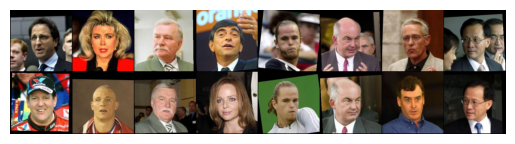

[0 0 1 0 1 1 0 1]


In [91]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iterations, losses):
    plt.plot(iterations, losses)
    plt.show()

dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

example_batch = next(iter(dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

Una vez tratado el dataset, estamos en condiciones de ir a por el entrenamiento. No se mencionó antes, pero se usará como backbone una Resnet18, que sabemos da muy buenos resultados y se usa para resolver problemas de clasificación con rostros (ImageNet). La entrenaremos desde cero pues queremos ver cómo se comportan las redes siamesas, compartiendo los pesos de la estructura de la red. Como mencionábamos, usaremos como función de pérdida la ***ContrastiveLoss***. Como optimizador usaremos el comúnmente usado y conocido Adam.

In [96]:
model = SiameseNetwork().cuda()
criterion = ContrastiveLoss(margin=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Definimos la siguiente función, que entrenará dados los parámetros necesarios nuestra red siamesa, en principio durante 10 épocas. El proceso de entrenamiento es totálmente an

In [97]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (img1, img2, label) in enumerate(train_loader):
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

            optimizer.zero_grad()

            output1, output2 = model(img1, img2)

            euclidean_distance = torch.pairwise_distance(output1, output2)

            if i % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Avg. Euclidean Distance: {euclidean_distance.mean().item()}')

            loss = criterion(output1, output2, label)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

**Antes de pasar a la evaluación:** A modo de resumen antes de pasar a la evaluación del modelo, lo que estamos haciendo es generar para cada imagen un **embedding**. Sería como si en un espacio de dimensión 256 (el tamaño que hemos escogido de salida de la red) consiguiéramos representar cada una de las imágenes. Estos embeddings, la red ha sido entrenada para que los ubique dependiendo de su distancia. Para las imágenes que sean de la misma persona queremos que sus embeddings tengan la menor distancia euclídea posible (se podría usar otra distancia). Para las que son de personas distintas, queremos que estén lo más separadas posible.

$$$$

Ahora sí, podemos pasar a la evaluación de nuestra red. Para ello vamos a seguir el siguiente esquema. Es parecido al usado en FaceNet:

In [98]:
def evaluate(model, test_loader, threshold):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

            output1, output2 = model(img1, img2)

            euclidean_distance = torch.pairwise_distance(output1, output2)
            predictions = (euclidean_distance < threshold).float()

            total_samples += label.size(0)
            total_correct += (predictions == label).sum().item()

    accuracy = total_correct / total_samples
    print(f'Accuracy: {accuracy * 100:.2f}%')

In [99]:
train(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Batch [1/69], Avg. Euclidean Distance: 0.7815107107162476
Epoch [1/10], Batch [11/69], Avg. Euclidean Distance: 0.10423018038272858
Epoch [1/10], Batch [21/69], Avg. Euclidean Distance: 0.06598518043756485
Epoch [1/10], Batch [31/69], Avg. Euclidean Distance: 0.07708416134119034
Epoch [1/10], Batch [41/69], Avg. Euclidean Distance: 0.12706062197685242
Epoch [1/10], Batch [51/69], Avg. Euclidean Distance: 0.11364591121673584
Epoch [1/10], Batch [61/69], Avg. Euclidean Distance: 0.09461672604084015
Epoch [1/10], Loss: 0.0087
Epoch [2/10], Batch [1/69], Avg. Euclidean Distance: 0.11004143208265305
Epoch [2/10], Batch [11/69], Avg. Euclidean Distance: 0.11501181870698929
Epoch [2/10], Batch [21/69], Avg. Euclidean Distance: 0.11029623448848724
Epoch [2/10], Batch [31/69], Avg. Euclidean Distance: 0.09558167308568954
Epoch [2/10], Batch [41/69], Avg. Euclidean Distance: 0.10697315633296967
Epoch [2/10], Batch [51/69], Avg. Euclidean Distance: 0.1135031208395958
Epoch [2/10], B

In [100]:
thresholds = [0.05, 0.1, 0.15, 0.2]

for threshold in thresholds:
    print(f"\nThreshold: {threshold}")
    evaluate(model, test_loader, threshold)


Threshold: 0.05
Accuracy: 65.20%

Threshold: 0.1
Accuracy: 81.60%

Threshold: 0.15
Accuracy: 76.20%

Threshold: 0.2
Accuracy: 64.60%


In [31]:
def predict_top_n(input_tensor, model, dataset, n=5):

    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    if input_tensor.dim() == 3:
        input_tensor = input_tensor.unsqueeze(0)

    with torch.no_grad():
        output1, output2 = model(input_tensor, input_tensor)

    similarities = []
    embeddings = []

    for i in range(len(dataset)):
        image, image2, _ = dataset[i]

        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            embedding, embedding2 = model(image, image)

        similarity = torch.cosine_similarity(output1, embedding).item()
        similarities.append((similarity, i))
        embeddings.append(embedding)

    similarities.sort(key=lambda x: x[0], reverse=True)
    top_n_similarities = similarities[:n]

    results = []
    for similarity, index in top_n_similarities:
        results.append((dataset[index][0], similarity, embeddings[index], index))

    return results

In [101]:
dataloader = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size= 1)
image_to_compare, _, _ = next(iter(dataloader))

resultado = predict_top_n(image_to_compare, model, train_dataset)

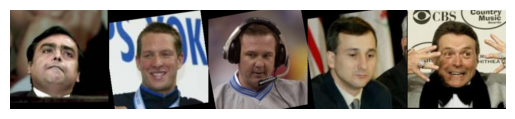

In [102]:
image_tensors = [result[0] for result in resultado]
concatenated = torch.cat(image_tensors, dim=2)
imshow(concatenated)

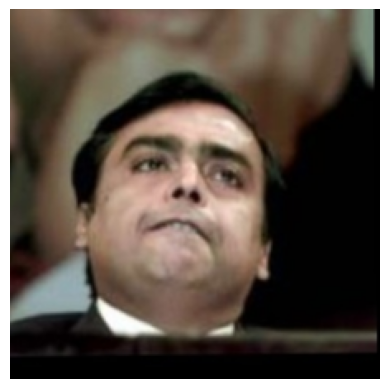

In [103]:
imshow(image_to_compare.squeeze(0))

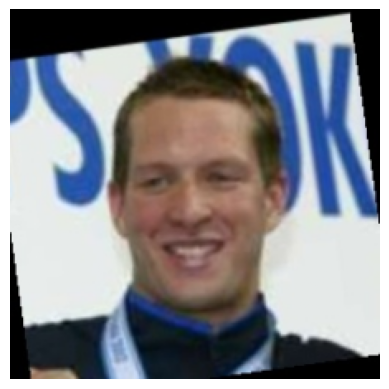

In [104]:
imshow(resultado[1][0].squeeze(0))

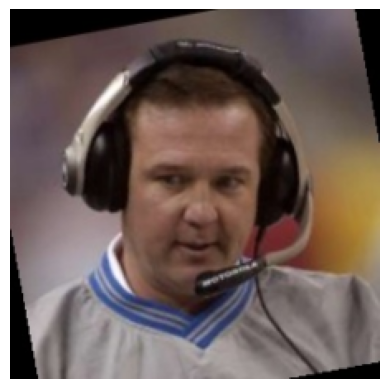

In [105]:
imshow(resultado[2][0].squeeze(0))

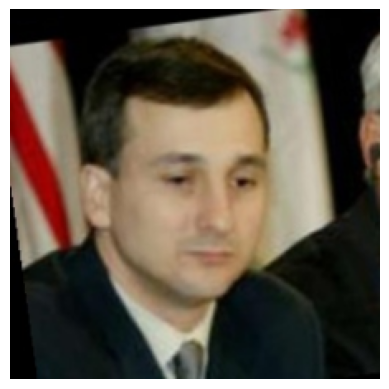

In [106]:
imshow(resultado[3][0].squeeze(0))

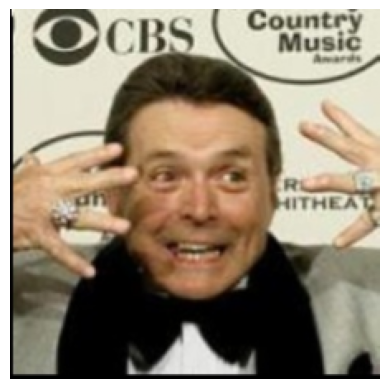

In [107]:
imshow(resultado[4][0].squeeze(0))

Probemos ahora con distintos tamaños para los embeddings y comparemos:

$$$$

**Tamaño 128**

In [121]:
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Identity()
        self.fc = nn.Linear(512, 128)  # Cambiamos a 128
        self.norm = Norm_L2()

    def forward_one(self, x):
        x = self.resnet18(x)
        x = self.fc(x)
        x = self.norm(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [122]:
model128 = SiameseNetwork().cuda()
criterion = ContrastiveLoss(margin=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [123]:
train(model128, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Batch [1/69], Avg. Euclidean Distance: 0.7422949075698853
Epoch [1/10], Batch [11/69], Avg. Euclidean Distance: 0.7444033622741699
Epoch [1/10], Batch [21/69], Avg. Euclidean Distance: 0.7663354277610779
Epoch [1/10], Batch [31/69], Avg. Euclidean Distance: 0.7705776691436768
Epoch [1/10], Batch [41/69], Avg. Euclidean Distance: 0.7397864460945129
Epoch [1/10], Batch [51/69], Avg. Euclidean Distance: 0.734534740447998
Epoch [1/10], Batch [61/69], Avg. Euclidean Distance: 0.7705912590026855
Epoch [1/10], Loss: 0.1323
Epoch [2/10], Batch [1/69], Avg. Euclidean Distance: 0.7633859515190125
Epoch [2/10], Batch [11/69], Avg. Euclidean Distance: 0.7478280663490295
Epoch [2/10], Batch [21/69], Avg. Euclidean Distance: 0.7672061920166016
Epoch [2/10], Batch [31/69], Avg. Euclidean Distance: 0.7634240388870239
Epoch [2/10], Batch [41/69], Avg. Euclidean Distance: 0.7421590685844421
Epoch [2/10], Batch [51/69], Avg. Euclidean Distance: 0.7575249075889587
Epoch [2/10], Batch [61/69]

In [124]:
thresholds = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

for threshold in thresholds:
    print(f"\nThreshold: {threshold}")
    evaluate(model128, test_loader, threshold)


Threshold: 0.65
Accuracy: 58.70%

Threshold: 0.7
Accuracy: 65.00%

Threshold: 0.75
Accuracy: 69.80%

Threshold: 0.8
Accuracy: 67.90%

Threshold: 0.85
Accuracy: 62.70%

Threshold: 0.9
Accuracy: 56.20%


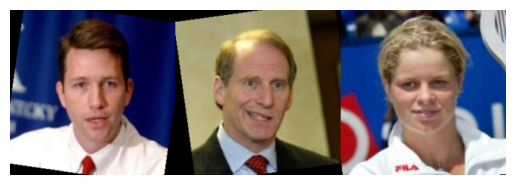

In [131]:
dataloader = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size= 1)
image_to_compare, _, _ = next(iter(dataloader))

resultado = predict_top_n(image_to_compare, model128, train_dataset, n = 3)

image_tensors = [result[0] for result in resultado]
concatenated = torch.cat(image_tensors, dim=2)
imshow(concatenated)

**Tamaño 64 de embedding**

In [116]:
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Identity()
        self.fc = nn.Linear(512, 64)  # Cambiamos a 64
        self.norm = Norm_L2()

    def forward_one(self, x):
        x = self.resnet18(x)
        x = self.fc(x)
        x = self.norm(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [117]:
model64 = SiameseNetwork().cuda()
criterion = ContrastiveLoss(margin=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [118]:
train(model64, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Batch [1/69], Avg. Euclidean Distance: 0.7508741617202759
Epoch [1/10], Batch [11/69], Avg. Euclidean Distance: 0.7633757591247559
Epoch [1/10], Batch [21/69], Avg. Euclidean Distance: 0.7785800099372864
Epoch [1/10], Batch [31/69], Avg. Euclidean Distance: 0.7617802023887634
Epoch [1/10], Batch [41/69], Avg. Euclidean Distance: 0.7757989168167114
Epoch [1/10], Batch [51/69], Avg. Euclidean Distance: 0.7359182834625244
Epoch [1/10], Batch [61/69], Avg. Euclidean Distance: 0.7800872325897217
Epoch [1/10], Loss: 0.1290
Epoch [2/10], Batch [1/69], Avg. Euclidean Distance: 0.7482242584228516
Epoch [2/10], Batch [11/69], Avg. Euclidean Distance: 0.7680795192718506
Epoch [2/10], Batch [21/69], Avg. Euclidean Distance: 0.7337563037872314
Epoch [2/10], Batch [31/69], Avg. Euclidean Distance: 0.7672286033630371
Epoch [2/10], Batch [41/69], Avg. Euclidean Distance: 0.7758832573890686
Epoch [2/10], Batch [51/69], Avg. Euclidean Distance: 0.774045467376709
Epoch [2/10], Batch [61/69]

In [119]:
thresholds = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

for threshold in thresholds:
    print(f"\nThreshold: {threshold}")
    evaluate(model64, test_loader, threshold)


Threshold: 0.6
Accuracy: 56.60%

Threshold: 0.65
Accuracy: 61.60%

Threshold: 0.7
Accuracy: 64.90%

Threshold: 0.75
Accuracy: 66.60%

Threshold: 0.8
Accuracy: 64.70%

Threshold: 0.85
Accuracy: 62.30%


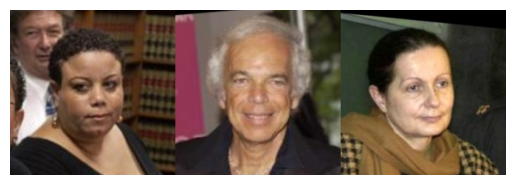

In [135]:
dataloader = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size= 1)
image_to_compare, _, _ = next(iter(dataloader))

resultado = predict_top_n(image_to_compare, model64, train_dataset, n = 3)

image_tensors = [result[0] for result in resultado]
concatenated = torch.cat(image_tensors, dim=2)
imshow(concatenated)